In [1]:
# Input data
import numpy as np
from utilities import *

# test and train read
X_train_valid, Y_train_valid, list_ch_train_valid = read_data(data_path="../../../datasets/har/har-data/", 
                                                              split="train")
X_test, Y_test, list_ch_test = read_data(data_path="../../../datasets/har/har-data/", split="test")

assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)

print(np.mean(Y_train_valid==0), np.mean(Y_train_valid==1), np.mean(Y_train_valid==2), 
      np.mean(Y_train_valid==3), np.mean(Y_train_valid==4), np.mean(Y_train_valid==5),
      np.mean(Y_train_valid==6), np.mean(Y_train_valid==7))

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0


In [2]:
# Preparing input and output data
# from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid).reshape(-1)==0), np.mean((Y_train_valid).reshape(-1)==1),
     np.mean((Y_train_valid).reshape(-1)==2), np.mean((Y_train_valid).reshape(-1)==3),
     np.mean((Y_train_valid).reshape(-1)==4), np.mean((Y_train_valid).reshape(-1)==5),
     np.mean((Y_train_valid).reshape(-1)==6), np.mean((Y_train_valid).reshape(-1)==7))

Y_train_valid_onehot = one_hot(labels=Y_train_valid.reshape(-1), n_class=6) 
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=6) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0
(7352, 6) float64 (2947, 6) float64


In [3]:
# Train and valid split
from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(5146, 128, 9) (2206, 128, 9) (5146, 6) (2206, 6)


In [4]:
## Hyperparameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

batch_size, seq_len, n_channels 51 128 9
n_classes 6


In [5]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [6]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')

In [33]:
# This is one convolution channel for example
print(inputs_.shape, inputs_.dtype)
# variable/weight shape should be based on NWC but the other way around WCN
# Width, Channels, Number of weights
Wwidth, Wchannels, Wnumber = inputs_.shape[1].value//2, inputs_.shape[2].value, inputs_.shape[2].value*2 # double up the input channels
shape = [Wwidth, Wchannels, Wnumber]
# print(shape)
# initializing the weight using normal
initial_value = tf.random_normal(dtype=inputs_.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
# Weight, variable and itsshape
Wconv = tf.Variable(dtype=inputs_.dtype, initial_value=initial_value, name=None, trainable=True)
print(Wconv.shape, Wconv.dtype)
# input shape and type as the input tensor
# convolution operation as well
Xconv = tf.nn.conv1d(data_format='NWC', filters=Wconv, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=inputs_)
print(Xconv.shape, Xconv.dtype)

(?, 128, 9) <dtype: 'float32'>
(64, 9, 18) <dtype: 'float32_ref'>
(?, 64, 18) <dtype: 'float32'>


In [53]:
# This is one multiplication channel for example
# Flatten and add dropout + predicted output
# WHY!!!!!!!! this is not working!!
# shape = [Xconv.shape[0].value, Xconv.shape[1].value*Xconv.shape[2].value]
shape = [-1, Xconv.shape[1].value*Xconv.shape[2].value]
# print(shape, 64*18) # as a double check
Xconv_reshaped = tf.reshape(name=None, shape=shape, tensor=Xconv)
print(Xconv_reshaped.shape, Xconv_reshaped.dtype)
# The weight for fully connected/dense layer and for multiplication not convolution though.
# multiplication is so much easier than convolution in terms of implementation.
# shape = this shape should be the same NWC as well but the other way around or maybe transposed
# X is NWC which is describing the tensor shape0, 1, 2
# labels which are the output labels are supposed to be NC, 
# N:batch size, C: output channels or output classes or dimensions 
Wchannels, Wnumber = Xconv_reshaped.shape[1].value, labels_.shape[1].value
shape = [Wchannels, Wnumber]
# print(shape)
initial_value = tf.random_normal(dtype=Xconv_reshaped.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
W = tf.Variable(dtype=Xconv_reshaped.dtype, initial_value=initial_value, name=None, trainable=True)
print(W.shape, W.dtype)
logits = tf.matmul(a=Xconv_reshaped, b=W, name=None)
print(logits.shape, logits.dtype)
print(labels_.shape, labels_.dtype)

(?, 1152) <dtype: 'float32'>
(1152, 6) <dtype: 'float32_ref'>
(?, 6) <dtype: 'float32'>
(?, 6) <dtype: 'float32'>


In [54]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )
# minimize(
#     loss,
#     global_step=None,
#     var_list=None,
#     gate_gradients=GATE_OP,
#     aggregation_method=None,
#     colocate_gradients_with_ops=False,
#     name=None,
#     grad_loss=None
# )
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("softmax_cross_entropy_with_logits_sg_2/Reshape_2:0", shape=(?,), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32)
optimizer name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_Variable_4/ApplyAdam"
input: "^Adam_1/update_Variable_10/ApplyAdam"
input: "^Adam_1/Assign"
input: "^Adam_1/Assign_1"

correct_pred, accuracy Tensor("Equal_1:0", shape=(?,), dtype=bool) Tensor("accuracy_1:0", shape=(), dtype=float32)


In [55]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    epochs=10
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints/dcnn-lstm-har.ckpt")

Epoch: 1/10 Train loss: 551.355530 Valid loss: 573.306580 Train acc: 0.318824 Valid acc: 0.324701
Epoch: 2/10 Train loss: 455.412018 Valid loss: 479.821899 Train acc: 0.386765 Valid acc: 0.388874
Epoch: 3/10 Train loss: 401.286957 Valid loss: 428.362152 Train acc: 0.418235 Valid acc: 0.415543
Epoch: 4/10 Train loss: 363.619720 Valid loss: 393.262970 Train acc: 0.439314 Valid acc: 0.432045
Epoch: 5/10 Train loss: 334.899048 Valid loss: 366.759949 Train acc: 0.453843 Valid acc: 0.443161
Epoch: 6/10 Train loss: 311.786377 Valid loss: 345.564514 Train acc: 0.465360 Valid acc: 0.451410
Epoch: 7/10 Train loss: 292.587799 Valid loss: 327.924194 Train acc: 0.474678 Valid acc: 0.458248
Epoch: 8/10 Train loss: 276.216705 Valid loss: 312.834412 Train acc: 0.482917 Valid acc: 0.463734
Epoch: 9/10 Train loss: 261.978912 Valid loss: 299.691956 Train acc: 0.489739 Valid acc: 0.468510
Epoch: 10/10 Train loss: 249.435013 Valid loss: 288.091339 Train acc: 0.495765 Valid acc: 0.472532


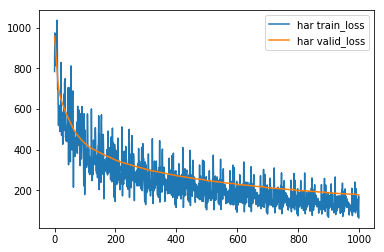

In [57]:
import matplotlib.pyplot as mplot
# % %matplotlib inline
# this is keeping the mpl inline or outline
# inline would inside this block and outline/out of block would be out of this block.
%matplotlib inline

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

In [58]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/dcnn-lstm-har.ckpt
Test loss: 215.166290 Test acc: 0.472652
